# Data Manipulation

## Primary Dataset

### Menstrual Cycle Regularity

Menstrual cycle regularity in the past 12 months was assessed by asking participants whether they experienced regular periods. Participants were classified as having regular cycles if they reported consistent menstrual bleeding patterns. Participants who reported irregular cycles were classified as having irregular cycles, provided that no notable medical or physiological reasons were present.

**Participants were excluded from the irregularity classification if they had conditions or circumstances that naturally prevent menstruation, including: pregnancy, postpartum or breastfeeding-related amenorrhea, hysterectomy, or menopause.** This approach ensures that the measure of cycle irregularity reflects only those individuals for whom menstrual cycles would be expected under normal conditions.

In [710]:
#Imports
import pandas as pd
import numpy as np

#### Reproductive Health

In [711]:
# Load reproductive health dataset XPT file
cycle_17_to_pre20 = pd.read_sas('data/P_RHQ.XPT')
cycle_21_to_23 = pd.read_sas('data/RHQ_L.XPT')

# See what’s inside
print(cycle_17_to_pre20.shape)
print(cycle_21_to_23.shape)

(5314, 32)
(3917, 13)


In [712]:
# Find overlapping columns
cycle_common_cols = cycle_17_to_pre20.columns.intersection(cycle_21_to_23.columns)

# Keep only overlapping columns
cycle_df = pd.concat([cycle_17_to_pre20[cycle_common_cols], cycle_21_to_23[cycle_common_cols]], axis=0, ignore_index=True)

In [713]:
# Rename variables of interest
cycle_df.rename(columns={
    'RHQ031': 'Regular_Periods',
    'RHD043': 'Irregular_Period_Reason'
}, inplace=True)

In [714]:
# Map categorical values (others become NaN automatically)
cycle_df['Regular_Periods'] = cycle_df['Regular_Periods'].map({
    1: 'Yes', 
    2: 'No'
})

In [715]:
#Drop rows where Regular_Periods = NaN
cycle_df.dropna(subset=['Regular_Periods'],inplace=True)

# Drop rows where Irregular_Period_Reason = pregnancy (1), breast feeding (2), hysterectomy (3), or menopause (7)
cycle_df = cycle_df[~cycle_df['Irregular_Period_Reason'].isin([1, 2, 3, 7])]

In [716]:
#Retain variables of interest only
cycle_df = cycle_df[['SEQN', 'Regular_Periods']]

In [717]:
cycle_df

,SEQN,Regular_Periods
0,109264.0,Yes
1,109266.0,Yes
2,109277.0,Yes
3,109279.0,Yes
4,109284.0,Yes
...,...,...
9214,142263.0,Yes
9217,142269.0,No
9220,142280.0,Yes
9221,142283.0,Yes


In [718]:
#Confirm only specified values remain in fields
print(cycle_df['Regular_Periods'].value_counts())

#Check value & N/A counts
print('Values: ',cycle_df['Regular_Periods'].value_counts().sum())
print('N/A: ',cycle_df['Regular_Periods'].isna().sum())
print('Total: ',cycle_df['Regular_Periods'].isna().value_counts().sum())

Regular_Periods
Yes    4063
No      396
Name: count, dtype: int64
Values:  4459
N/A:  0
Total:  4459


#### Demographics

In [719]:
# Load demographic dataset XPT file
demo_17_to_pre20 = pd.read_sas('data/P_DEMO.XPT')
demo_21_to_23 = pd.read_sas('data/DEMO_L.XPT')

# See what’s inside
print(demo_17_to_pre20.shape)
print(demo_21_to_23.shape)

(15560, 29)
(11933, 27)


In [720]:
# Find overlapping columns
demo_common_cols = demo_17_to_pre20.columns.intersection(demo_21_to_23.columns)

# Keep only overlapping columns
demo_df = pd.concat([demo_17_to_pre20[demo_common_cols], demo_21_to_23[demo_common_cols]], axis=0, ignore_index=True)

In [721]:
# Merge cycle_df and demo_df on SEQN (common ID)
demo_df = pd.merge(cycle_df, demo_df, on='SEQN', how='left')

In [722]:
# Rename variables of interest
#Already filtering by sex based on cycle data only coming from females
demo_df.rename(columns={
    'RIDRETH3': 'Race',
    'RIDAGEYR': 'Age',
    'DMDEDUC2': 'Education',
    'INDFMPIR': 'Family_Income_to_Poverty_Ratio'
}, inplace=True)

In [723]:
# Map categorical values
demo_df['Race'] = demo_df['Race'].map({
    1: 'Mexican American', 
    2: 'Other Hispanic',
    3: 'Non-Hispanic White', 
    4: 'Non-Hispanic Black',
    6: 'Non-Hispanic Asian',
    7: 'Other Race - Including Multi-Racial'
})
demo_df['Education'] = demo_df['Education'].map({
    1: 'Less than 9th grade',
    2: '9-11th grade',
    3: 'High school/GED',
    4: 'Some college/AA',
    5: 'College graduate or above'
})

In [724]:
#Drop rows where Age <18 & >50
#18 lower limit based on some datasets only containing data from adults (18+)
#50 upper limit based on medical research: https://www.mayoclinic.org/diseases-conditions/menopause/symptoms-causes/syc-20353397
demo_df = demo_df[(demo_df['Age'] >= 18) & (demo_df['Age'] <= 50)]

In [725]:
#Retain variables of interest only
demo_df = demo_df[['SEQN', 'Regular_Periods', 'Race', 'Age', 'Education', 'Family_Income_to_Poverty_Ratio']]

In [726]:
demo_df

,SEQN,Regular_Periods,Race,Age,Education,Family_Income_to_Poverty_Ratio
1,109266.0,Yes,Non-Hispanic Asian,29.0,College graduate or above,5.00
4,109284.0,Yes,Mexican American,44.0,9-11th grade,NaN
5,109291.0,Yes,Non-Hispanic Asian,42.0,College graduate or above,NaN
7,109297.0,Yes,Non-Hispanic Asian,30.0,Some college/AA,NaN
8,109312.0,Yes,Non-Hispanic White,48.0,College graduate or above,5.00
...,...,...,...,...,...,...
4454,142263.0,Yes,Non-Hispanic White,44.0,College graduate or above,NaN
4455,142269.0,No,Non-Hispanic Black,32.0,Some college/AA,0.74
4456,142280.0,Yes,Other Race - Including Multi-Racial,23.0,Some college/AA,1.40
4457,142283.0,Yes,Other Race - Including Multi-Racial,29.0,High school/GED,1.04


In [727]:
#Confirm only specified values remain in fields
print(demo_df['Age'].value_counts())

#Check value & N/A counts
print('Values: ',demo_df['Age'].value_counts().sum())
print('N/A: ',demo_df['Age'].isna().sum())
print('Total: ',demo_df['Age'].isna().value_counts().sum())

Age
19.0    163
18.0    141
39.0    124
34.0    114
29.0    110
31.0    107
33.0    104
37.0    104
32.0    101
41.0    100
23.0    100
28.0     97
44.0     96
43.0     96
35.0     96
25.0     96
30.0     95
42.0     94
27.0     94
38.0     92
40.0     92
36.0     91
21.0     89
24.0     87
22.0     85
45.0     83
20.0     81
47.0     81
26.0     78
48.0     74
46.0     72
50.0     56
49.0     50
Name: count, dtype: int64
Values:  3143
N/A:  0
Total:  3143


In [728]:
#Filter cycle_df by age 18-50 now that we have age range from demo_df
cycle_df = demo_df[['SEQN', 'Regular_Periods']]

In [729]:
cycle_df

,SEQN,Regular_Periods
1,109266.0,Yes
4,109284.0,Yes
5,109291.0,Yes
7,109297.0,Yes
8,109312.0,Yes
...,...,...
4454,142263.0,Yes
4455,142269.0,No
4456,142280.0,Yes
4457,142283.0,Yes


In [730]:
# Merge cycle_df and demo_df on their common column(s)
# If both have 'SEQN', pandas will use that as the default key
primary_dataset = pd.merge(cycle_df, demo_df, on=["SEQN","Regular_Periods"], how="left")


In [731]:
primary_dataset

,SEQN,Regular_Periods,Race,Age,Education,Family_Income_to_Poverty_Ratio
0,109266.0,Yes,Non-Hispanic Asian,29.0,College graduate or above,5.00
1,109284.0,Yes,Mexican American,44.0,9-11th grade,NaN
2,109291.0,Yes,Non-Hispanic Asian,42.0,College graduate or above,NaN
3,109297.0,Yes,Non-Hispanic Asian,30.0,Some college/AA,NaN
4,109312.0,Yes,Non-Hispanic White,48.0,College graduate or above,5.00
...,...,...,...,...,...,...
3138,142263.0,Yes,Non-Hispanic White,44.0,College graduate or above,NaN
3139,142269.0,No,Non-Hispanic Black,32.0,Some college/AA,0.74
3140,142280.0,Yes,Other Race - Including Multi-Racial,23.0,Some college/AA,1.40
3141,142283.0,Yes,Other Race - Including Multi-Racial,29.0,High school/GED,1.04


/usr/local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

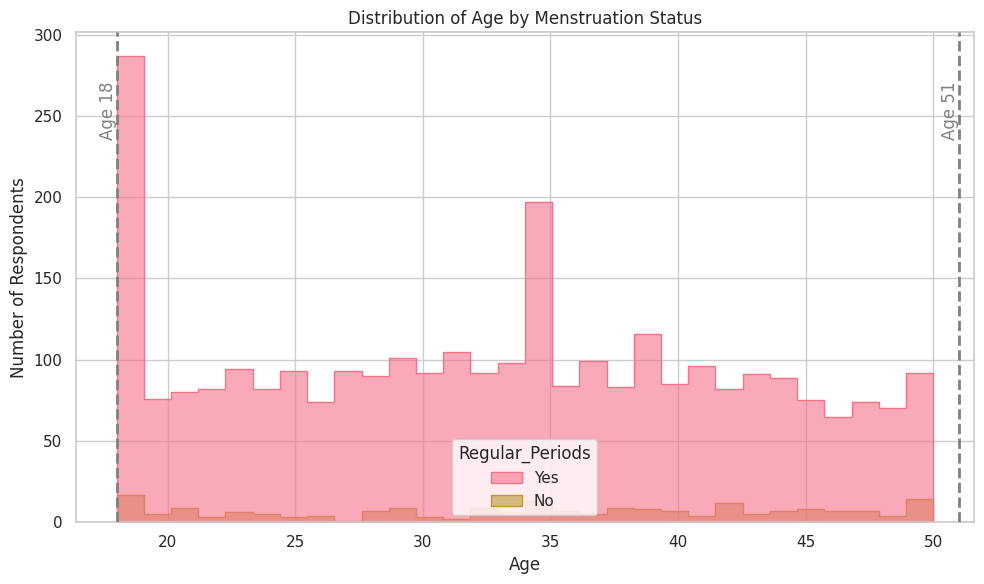

In [732]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.histplot(
    data=primary_dataset,
    x="Age",
    hue="Regular_Periods",   # split by menstruation status
    bins=30,
    kde=False,
    element="step",         # outlines for easier comparison
    stat="count",           # you could also use "percent"
    alpha=0.6
)

# Add vertical lines at age 18 and 60
plt.axvline(x=18, color='gray', linestyle='--', linewidth=2, zorder=5)
plt.axvline(x=51, color='gray', linestyle='--', linewidth=2, zorder=5)

# Labels for the lines
plt.text(18, plt.ylim()[1]*0.9, 'Age 18', rotation=90, color='gray', ha='right', va='top')
plt.text(51, plt.ylim()[1]*0.9, 'Age 51', rotation=90, color='gray', ha='right', va='top')

plt.title("Distribution of Age by Menstruation Status")
plt.xlabel("Age")
plt.ylabel("Number of Respondents")

plt.tight_layout()
plt.show()

## Secondary Dataset
- Body Measures (height, weight, BMI)
- Smoking (smoking status, frequency, history)
- Alcohol Consumption
- Physical Activity (activity type, frequency, duration, intensity)
- Demographics (age, race/ethnicity, education, income)
- Dietary Data (diet quality, caloric and nutrient intake)
- Sleep Disorders (sleep quality, trouble sleeping, sleep duration)

#### Body Measures (height, weight, BMI)

In [733]:
# Load body measures dataset XPT file
bmi_17_to_pre20 = pd.read_sas('data/P_BMX.XPT')
bmi_21_to_23 = pd.read_sas('data/BMX_L.XPT')

weight_17_to_pre20 = pd.read_sas('data/P_WHQ.XPT')
weight_21_to_23 = pd.read_sas('data/WHQ_L.XPT')

# See what’s inside
print(bmi_17_to_pre20.shape)
print(bmi_21_to_23.shape)

print(weight_17_to_pre20.shape)
print(weight_21_to_23.shape)

(14300, 22)
(8860, 22)
(10195, 35)
(8501, 5)


In [734]:
# Find overlapping columns
bmi_common_cols = bmi_17_to_pre20.columns.intersection(bmi_21_to_23.columns)
weight_common_cols = weight_17_to_pre20.columns.intersection(weight_21_to_23.columns)

# Keep only overlapping columns
bmi_df = pd.concat([bmi_17_to_pre20[bmi_common_cols], bmi_21_to_23[bmi_common_cols]], axis=0, ignore_index=True)
weight_df = pd.concat([weight_17_to_pre20[weight_common_cols], weight_21_to_23[weight_common_cols]], axis=0, ignore_index=True)

In [735]:
# Merge cycle_df and bmi_df on SEQN (common ID)
bmi_df = pd.merge(cycle_df, bmi_df, on='SEQN', how='left')
bmi_df = pd.merge(bmi_df, weight_df, on='SEQN', how='left')

In [736]:
# Rename variables of interest
bmi_df.rename(columns={
    'BMXBMI': 'BMI',
    'BMXWAIST': 'Waist_circum_cm',
    'BMXHIP': 'Hip_Circum_cm',
    'WHQ070': 'Attempted_Weight_Loss',
    'WHD010': 'Height_in',
    'WHD020': 'Weight_lbs',
    'WHD050': 'Prev_Weight_lbs'
}, inplace=True)

In [737]:
# Map categorical values
bmi_df['Attempted_Weight_Loss'] = bmi_df['Attempted_Weight_Loss'].map({
    1: 'Yes',
    2: 'No'
})
#Using replace over map since range values need to be retained
bmi_df['Height_in'] = bmi_df['Height_in'].replace(7777, np.nan).replace(9999, np.nan)
bmi_df['Weight_lbs'] = bmi_df['Weight_lbs'].replace(7777, np.nan).replace(9999, np.nan)
bmi_df['Prev_Weight_lbs'] = bmi_df['Prev_Weight_lbs'].replace(7777, np.nan).replace(9999, np.nan)

In [738]:
# No additional rows need to be dropped

In [739]:
# Add calculation column for weight loss
bmi_df['Weight_Change_lbs'] = bmi_df['Prev_Weight_lbs'] - bmi_df['Weight_lbs']

In [740]:
#Retain variables of interest only
bmi_df = bmi_df[['SEQN','BMI', 'Waist_circum_cm', 'Hip_Circum_cm', 'Attempted_Weight_Loss', 'Height_in', 'Weight_lbs', 'Weight_Change_lbs']]

In [741]:
bmi_df

,SEQN,BMI,Waist_circum_cm,Hip_Circum_cm,Attempted_Weight_Loss,Height_in,Weight_lbs,Weight_Change_lbs
0,109266.0,37.8,117.9,126.1,Yes,64.0,210.0,-10.0
1,109284.0,39.1,103.1,125.5,Yes,60.0,178.0,-8.0
2,109291.0,31.3,NaN,NaN,No,64.0,148.0,-8.0
3,109297.0,23.2,73.2,92.5,Yes,60.0,120.0,-5.0
4,109312.0,23.9,95.7,96.3,No,66.0,139.0,0.0
...,...,...,...,...,...,...,...,...
3138,142263.0,22.6,80.4,95.0,No,65.0,135.0,0.0
3139,142269.0,NaN,149.3,147.2,No,64.0,350.0,0.0
3140,142280.0,38.4,124.1,130.0,Yes,69.0,250.0,20.0
3141,142283.0,45.8,137.2,145.7,Yes,67.0,275.0,5.0


In [742]:
#Confirm only specified values remain in fields
print(bmi_df['BMI'].value_counts())

#Check value & N/A counts
print('Values: ',bmi_df['BMI'].value_counts().sum())
print('N/A: ',bmi_df['BMI'].isna().sum())
print('Total: ',bmi_df['BMI'].isna().value_counts().sum())

BMI
25.2    24
23.5    24
26.1    24
21.6    23
22.7    22
        ..
49.0     1
54.7     1
64.2     1
14.8     1
45.1     1
Name: count, Length: 407, dtype: int64
Values:  3112
N/A:  31
Total:  3143


#### Smoking (smoking status, frequency, history)

In [743]:
# Load smoking dataset XPT files
smoking_cig_17_to_pre20 = pd.read_sas('data/P_SMQ.XPT')
smoking_cig_21_to_23 = pd.read_sas('data/SMQ_L.XPT')

smoking_house_17_to_pre20 = pd.read_sas('data/P_SMQFAM.XPT')
smoking_house_21_to_23 = pd.read_sas('data/SMQFAM_L.XPT')

smoking_tobacco_17_to_pre20 = pd.read_sas('data/P_SMQRTU.XPT')
smoking_tobacco_21_to_23 = pd.read_sas('data/SMQRTU_L.XPT')

# See what’s inside
print(smoking_cig_17_to_pre20.shape)
print(smoking_cig_21_to_23.shape)

print(smoking_house_17_to_pre20.shape)
print(smoking_house_21_to_23.shape)

print(smoking_tobacco_17_to_pre20.shape)
print(smoking_tobacco_21_to_23.shape)

(11137, 16)
(9015, 9)
(15560, 3)
(11933, 3)
(10409, 25)
(7199, 21)


In [744]:
# Find overlapping columns
smoking_cig_common_cols = smoking_cig_17_to_pre20.columns.intersection(smoking_cig_21_to_23.columns)
smoking_house_common_cols = smoking_house_17_to_pre20.columns.intersection(smoking_house_21_to_23.columns)
smoking_tobacco_common_cols = smoking_tobacco_17_to_pre20.columns.intersection(smoking_tobacco_21_to_23.columns)

# Keep only overlapping columns
smoking_cig = pd.concat([smoking_cig_17_to_pre20[smoking_cig_common_cols], smoking_cig_21_to_23[smoking_cig_common_cols]], axis=0, ignore_index=True)
smoking_house = pd.concat([smoking_house_17_to_pre20[smoking_house_common_cols], smoking_house_21_to_23[smoking_house_common_cols]], axis=0, ignore_index=True)
smoking_tobacco = pd.concat([smoking_tobacco_17_to_pre20[smoking_tobacco_common_cols], smoking_tobacco_21_to_23[smoking_tobacco_common_cols]], axis=0, ignore_index=True)

In [745]:
# Merge cycle_df and smoking dfs on SEQN (common ID)
smoking_df = pd.merge(cycle_df, smoking_cig, on='SEQN', how='left')
smoking_df = pd.merge(smoking_df, smoking_house, on='SEQN', how='left')
smoking_df = pd.merge(smoking_df, smoking_tobacco, on='SEQN', how='left')

In [746]:
# Rename variables of interest
smoking_df.rename(columns={
    'SMQ020': 'Smoked_100', 
    'SMQ040': 'Active_Smoker', 
    'SMQ621': 'Lifetime_Cig_Count',
    'SMD460': 'Household_Smoker_Count',
    'SMQ725': 'Last_Cig',
}, inplace=True)

In [747]:
# Map categorical values
smoking_df['Smoked_100'] = smoking_df['Smoked_100'].map({
    1: 'Yes', 
    2: 'No'})
smoking_df['Active_Smoker'] = smoking_df['Active_Smoker'].map({
    1: 'Every day', 
    2: 'Some days',
    3: 'Not at all'})
smoking_df['Lifetime_Cig_Count'] = smoking_df['Lifetime_Cig_Count'].map({
    1: 0, 
    2: '<1',
    3: 1,
    4: '2 to 5',
    5: '6 to 15',
    6: '16 to 25',
    7: '26 to 99',
    8: '100+'})
smoking_df['Household_Smoker_Count'] = smoking_df['Household_Smoker_Count'].map({
    5.397605346934028e-79: 0, #0 is being interpreted as 5.397605346934028e-79, the lowest IBM float value
    1: 1,
    2: '2+'})
smoking_df['Last_Cig'] = smoking_df['Last_Cig'].map({
    1: 'Today', 
    2: 'Yesterday',
    3: '3 to 5 days ago'})

In [748]:
# No additional rows need to be dropped

In [749]:
#Retain variables of interest only
smoking_df = smoking_df[['SEQN', 'Regular_Periods', 'Smoked_100', 'Active_Smoker', 'Lifetime_Cig_Count', 'Household_Smoker_Count', 'Last_Cig']]

In [750]:
smoking_df

,SEQN,Regular_Periods,Smoked_100,Active_Smoker,Lifetime_Cig_Count,Household_Smoker_Count,Last_Cig
0,109266.0,Yes,No,NaN,NaN,0,NaN
1,109284.0,Yes,No,NaN,NaN,0,NaN
2,109291.0,Yes,No,NaN,NaN,0,NaN
3,109297.0,Yes,No,NaN,NaN,0,Yesterday
4,109312.0,Yes,No,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...
3138,142263.0,Yes,No,NaN,NaN,0,NaN
3139,142269.0,No,No,NaN,NaN,0,NaN
3140,142280.0,Yes,No,NaN,NaN,0,NaN
3141,142283.0,Yes,No,NaN,NaN,0,NaN


In [751]:
#Confirm only specified values remain in fields
print(smoking_df['Smoked_100'].value_counts())

#Check value & N/A counts
print('Values: ',smoking_df['Smoked_100'].value_counts().sum())
print('N/A: ',smoking_df['Smoked_100'].isna().sum())
print('Total: ',smoking_df['Smoked_100'].isna().value_counts().sum())

Smoked_100
No     2315
Yes     825
Name: count, dtype: int64
Values:  3140
N/A:  3
Total:  3143


#### Alcohol

In [752]:
# Load alcohol dataset XPT files
alcohol_17_to_pre20 = pd.read_sas('data/P_ALQ.XPT')
alcohol_21_to_23 = pd.read_sas('data/ALQ_L.XPT')

# See what’s inside
print(alcohol_17_to_pre20.shape)
print(alcohol_21_to_23.shape)

(8965, 10)
(6337, 9)


In [753]:
# Find overlapping columns
alcohol_common_cols = alcohol_17_to_pre20.columns.intersection(alcohol_21_to_23.columns)

# Keep only overlapping columns
alcohol_df = pd.concat([alcohol_17_to_pre20[alcohol_common_cols], alcohol_21_to_23[alcohol_common_cols]], axis=0, ignore_index=True)

In [754]:
# Merge cycle_df and alcohol_df on SEQN (common ID)
alcohol_df = pd.merge(cycle_df, alcohol_df, on='SEQN', how='left')

In [755]:
# Rename variables of interest
alcohol_df.rename(columns={
    'ALQ121': 'Alc_Freq', 
    'ALQ130': 'Daily_Drinks',
}, inplace=True)

In [756]:
# Map categorical values
alcohol_df['Alc_Freq'] = alcohol_df['Alc_Freq'].map({
    5.397605346934028e-79: 'Never', #0 is being interpreted as 5.397605346934028e-79, the lowest IBM float value
    1: 'Every Day',
    2: 'Nearly Every Day',
    3: '3-4x/wk',
    4: '2x/wk',
    5: '1x/wk',
    6: '2-3x/mo',
    7: '1x/mo',
    8: '7-11x/yr',
    9: '3-6x/yr',
    10: '1-2x/yr'
})
#Using replace over map since range values need to be retained
alcohol_df['Daily_Drinks'] = alcohol_df['Daily_Drinks'].replace(15, '15+' ).replace(777, np.nan).replace(999, np.nan)

In [757]:
# No additional rows need to be dropped

In [758]:
#Retain variables of interest only
alcohol_df = alcohol_df[['SEQN', 'Alc_Freq', 'Daily_Drinks']]

In [759]:
alcohol_df

,SEQN,Alc_Freq,Daily_Drinks
0,109266.0,1-2x/yr,1.0
1,109284.0,NaN,NaN
2,109291.0,NaN,NaN
3,109297.0,2-3x/mo,2.0
4,109312.0,3-6x/yr,1.0
...,...,...,...
3138,142263.0,Never,NaN
3139,142269.0,3-6x/yr,2.0
3140,142280.0,1-2x/yr,3.0
3141,142283.0,2-3x/mo,2.0


In [760]:
#Confirm only specified values remain in fields
print(alcohol_df['Alc_Freq'].value_counts())

#Check value & N/A counts
print('Values: ',alcohol_df['Alc_Freq'].value_counts().sum())
print('N/A: ',alcohol_df['Alc_Freq'].isna().sum())
print('Total: ',alcohol_df['Alc_Freq'].isna().value_counts().sum())

Alc_Freq
2-3x/mo             510
3-6x/yr             401
1-2x/yr             391
Never               289
1x/mo               250
2x/wk               239
1x/wk               231
7-11x/yr            194
3-4x/wk             171
Nearly Every Day     64
Every Day            30
Name: count, dtype: int64
Values:  2770
N/A:  373
Total:  3143


#### Physical Activity

In [761]:
# Load physical activity dataset XPT files
exercise_17_to_pre20 = pd.read_sas('data/P_PAQ.XPT')
exercise_21_to_23 = pd.read_sas('data/PAQ_L.XPT')

# See what’s inside
print(exercise_17_to_pre20.shape)
print(exercise_21_to_23.shape)

(9693, 17)
(8153, 8)


In [762]:
# Keep all columns
exercise_df = pd.concat([exercise_17_to_pre20, exercise_21_to_23], axis=0, ignore_index=True)

In [763]:
# Merge cycle_df and exercise_df on SEQN (common ID)
exercise_df = pd.merge(cycle_df, exercise_df, on='SEQN', how='left')

In [764]:
# Rename variables of interest
exercise_df.rename(columns={
    'PAD680': 'Sedentary_Mins',
    'PAD790Q': 'Moderate_LTPA_Freq_1',
    'PAD790U': 'Moderate_LTPA_Units',
    'PAD800': 'Moderate_LTPA_Mins_1',
    'PAD810Q': 'Vigorous_LTPA_Freq_1',
    'PAD810U': 'Vigorous_LTPA_Units',
    'PAD820': 'Vigorous_LTPA_Mins_1',
    'PAQ610': 'Vigorous_LTPA_Freq_Work',
    'PAD615': 'Vigorous_LTPA_Mins_Work',
    'PAQ625': 'Moderate_LTPA_Freq_Work',
    'PAD630': 'Moderate_LTPA_Mins_Work',
    'PAQ655': 'Vigorous_LTPA_Freq_Rec',
    'PAD660': 'Vigorous_LTPA_Mins_Rec',
    'PAQ670': 'Moderate_LTPA_Freq_Rec',
    'PAD675': 'Moderate_LTPA_Mins_Rec'
}, inplace=True)

In [765]:
# Map categorical values
exercise_df['Moderate_LTPA_Units_Math'] = exercise_df['Moderate_LTPA_Units'].map({
    b'D': 365,
    b'M': 12,
    b'W': 52,
    b'Y': 1
})
exercise_df['Moderate_LTPA_Units_Text'] = exercise_df['Moderate_LTPA_Units'].map({
    b'D': 'day(s)',
    b'M': 'month(s)',
    b'W': 'week(s)',
    b'Y': 'year(s)'
})
exercise_df['Vigorous_LTPA_Units_Math'] = exercise_df['Vigorous_LTPA_Units'].map({
    b'D': 365,
    b'M': 12,
    b'W': 52,
    b'Y': 1
})
exercise_df['Vigorous_LTPA_Units_Text'] = exercise_df['Vigorous_LTPA_Units'].map({
    b'D': 'day(s)',
    b'M': 'month(s)',
    b'W': 'week(s)',
    b'Y': 'year(s)'
})

# Using replace over map since range values need to be retained
exercise_df['Sedentary_Mins'] = exercise_df['Sedentary_Mins'].replace(7777, np.nan).replace(9999, np.nan)

exercise_df['Moderate_LTPA_Freq_1'] = exercise_df['Moderate_LTPA_Freq_1'].replace(5.397605346934028e-79, 0).replace(7777, np.nan).replace(9999, np.nan)
exercise_df['Moderate_LTPA_Mins_1'] = exercise_df['Moderate_LTPA_Mins_1'].replace(7777, np.nan).replace(9999, np.nan)

exercise_df['Vigorous_LTPA_Freq_1'] = exercise_df['Vigorous_LTPA_Freq_1'].replace(5.397605346934028e-79, 0).replace(7777, np.nan).replace(9999, np.nan)
exercise_df['Vigorous_LTPA_Mins_1'] = exercise_df['Vigorous_LTPA_Mins_1'].replace(7777, np.nan).replace(9999, np.nan)

exercise_df['Moderate_LTPA_Freq_Work'] = exercise_df['Moderate_LTPA_Freq_Work'].replace(77, np.nan).replace(99, np.nan)
exercise_df['Moderate_LTPA_Mins_Work'] = exercise_df['Moderate_LTPA_Mins_Work'].replace(7777, np.nan).replace(9999, np.nan)

exercise_df['Vigorous_LTPA_Freq_Work'] = exercise_df['Vigorous_LTPA_Freq_Work'].replace(77, np.nan).replace(99, np.nan)
exercise_df['Vigorous_LTPA_Mins_Work'] = exercise_df['Vigorous_LTPA_Mins_Work'].replace(7777, np.nan).replace(9999, np.nan)

exercise_df['Moderate_LTPA_Freq_Rec'] = exercise_df['Moderate_LTPA_Freq_Rec'].replace(77, np.nan).replace(99, np.nan)
exercise_df['Moderate_LTPA_Mins_Rec'] = exercise_df['Moderate_LTPA_Mins_Rec'].replace(7777, np.nan).replace(9999, np.nan)

exercise_df['Vigorous_LTPA_Freq_Rec'] = exercise_df['Vigorous_LTPA_Freq_Rec'].replace(77, np.nan).replace(99, np.nan)
exercise_df['Vigorous_LTPA_Mins_Rec'] = exercise_df['Vigorous_LTPA_Mins_Rec'].replace(7777, np.nan).replace(9999, np.nan)

In [766]:
# No additional rows need to be dropped

In [767]:
# Add calculation columns for hrs per day & year
exercise_df['Sedentary_Hrs_Wk'] = exercise_df['Sedentary_Mins'] / 60 * 7

# Add calculation column for hrs per week avg
exercise_df['Moderate_LTPA_Hrs_Wk_1'] = exercise_df['Moderate_LTPA_Freq_1'] * exercise_df['Moderate_LTPA_Units_Math'].fillna(0).astype(int) * exercise_df['Moderate_LTPA_Mins_1'] / 60 / 52
exercise_df['Vigorous_LTPA_Hrs_Wk_1'] = exercise_df['Vigorous_LTPA_Freq_1'] * exercise_df['Vigorous_LTPA_Units_Math'].fillna(0).astype(int) * exercise_df['Vigorous_LTPA_Mins_1'] / 60 / 52
exercise_df['Moderate_LTPA_Hrs_Wk_Work'] = exercise_df['Moderate_LTPA_Freq_Work'] * exercise_df['Moderate_LTPA_Mins_Work'] / 60
exercise_df['Moderate_LTPA_Hrs_Wk_Rec'] = exercise_df['Moderate_LTPA_Freq_Rec'] * exercise_df['Moderate_LTPA_Mins_Rec'] / 60
exercise_df['Vigorous_LTPA_Hrs_Wk_Work'] = exercise_df['Vigorous_LTPA_Freq_Work'] * exercise_df['Vigorous_LTPA_Mins_Work'] / 60
exercise_df['Vigorous_LTPA_Hrs_Wk_Rec'] = exercise_df['Vigorous_LTPA_Freq_Rec'] * exercise_df['Vigorous_LTPA_Mins_Rec'] / 60

# Combine work & rec hrs per week fields
exercise_df['Moderate_LTPA_Hrs_Wk_2'] = exercise_df['Moderate_LTPA_Hrs_Wk_Work'] + exercise_df['Moderate_LTPA_Hrs_Wk_Rec']
exercise_df['Vigorous_LTPA_Hrs_Wk_2'] = exercise_df['Vigorous_LTPA_Hrs_Wk_Work'] + exercise_df['Vigorous_LTPA_Hrs_Wk_Rec']

# Combine hrs per week fields from 17-20 & 21-23 files
exercise_df['Moderate_LTPA_Hrs_Wk'] = exercise_df['Moderate_LTPA_Hrs_Wk_1'].combine_first(exercise_df['Moderate_LTPA_Hrs_Wk_2'])
exercise_df['Vigorous_LTPA_Hrs_Wk'] = exercise_df['Vigorous_LTPA_Hrs_Wk_1'].combine_first(exercise_df['Vigorous_LTPA_Hrs_Wk_2'])

# Combine work & rec freq fields
exercise_df['Moderate_LTPA_Freq_2'] = exercise_df['Moderate_LTPA_Freq_Work'] + exercise_df['Moderate_LTPA_Freq_Rec']
exercise_df['Vigorous_LTPA_Freq_2'] = exercise_df['Vigorous_LTPA_Freq_Work'] + exercise_df['Vigorous_LTPA_Freq_Rec']

# Combine work & rec mins fields
exercise_df['Moderate_LTPA_Mins_2'] = exercise_df['Moderate_LTPA_Mins_Work'] + exercise_df['Moderate_LTPA_Mins_Rec']
exercise_df['Vigorous_LTPA_Mins_2'] = exercise_df['Vigorous_LTPA_Mins_Work'] + exercise_df['Vigorous_LTPA_Mins_Rec']

# Modify freq field to include units
exercise_df['Moderate_LTPA_Freq_Units_1'] = exercise_df['Moderate_LTPA_Freq_1'].astype(str) + 'x/ ' + exercise_df['Moderate_LTPA_Units_Text']
exercise_df['Vigorous_LTPA_Freq_Units_1'] = exercise_df['Vigorous_LTPA_Freq_1'].astype(str) + 'x/ ' + exercise_df['Vigorous_LTPA_Units_Text']
exercise_df['Moderate_LTPA_Freq_Units_2'] = exercise_df['Moderate_LTPA_Freq_2'].where(exercise_df['Moderate_LTPA_Freq_2'].isna(), exercise_df['Moderate_LTPA_Freq_2'].astype(str) + 'x/ week')
exercise_df['Vigorous_LTPA_Freq_Units_2'] = exercise_df['Vigorous_LTPA_Freq_2'].where(exercise_df['Vigorous_LTPA_Freq_2'].isna(), exercise_df['Vigorous_LTPA_Freq_2'].astype(str) + 'x/ week')

# Combine freq fields from 17-20 & 21-23 files
exercise_df['Moderate_LTPA_Freq'] = exercise_df['Moderate_LTPA_Freq_Units_1'].combine_first(exercise_df['Moderate_LTPA_Freq_Units_2'])
exercise_df['Vigorous_LTPA_Freq'] = exercise_df['Vigorous_LTPA_Freq_Units_1'].combine_first(exercise_df['Vigorous_LTPA_Freq_Units_2'])

# Combine mins fields from 17-20 & 21-23 files
exercise_df['Moderate_LTPA_Mins'] = exercise_df['Moderate_LTPA_Mins_1'].combine_first(exercise_df['Moderate_LTPA_Mins_2'])
exercise_df['Vigorous_LTPA_Mins'] = exercise_df['Vigorous_LTPA_Mins_1'].combine_first(exercise_df['Vigorous_LTPA_Mins_2'])

In [768]:
#Retain variables of interest only
exercise_df = exercise_df[['SEQN', 'Regular_Periods', 'Sedentary_Hrs_Wk', 'Moderate_LTPA_Freq', 'Moderate_LTPA_Mins', 'Moderate_LTPA_Hrs_Wk', 'Vigorous_LTPA_Freq', 'Vigorous_LTPA_Mins', 'Vigorous_LTPA_Hrs_Wk']]

In [769]:
exercise_df

,SEQN,Regular_Periods,Sedentary_Hrs_Wk,Moderate_LTPA_Freq,Moderate_LTPA_Mins,Moderate_LTPA_Hrs_Wk,Vigorous_LTPA_Freq,Vigorous_LTPA_Mins,Vigorous_LTPA_Hrs_Wk
0,109266.0,Yes,56.0,NaN,NaN,NaN,NaN,NaN,NaN
1,109284.0,Yes,42.0,NaN,NaN,NaN,NaN,NaN,NaN
2,109291.0,Yes,63.0,NaN,NaN,NaN,NaN,NaN,NaN
3,109297.0,Yes,70.0,NaN,NaN,NaN,NaN,NaN,NaN
4,109312.0,Yes,21.0,12.0x/ week,480.0,52.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3138,142263.0,Yes,56.0,5.0x/ week(s),90.0,7.5,5.0x/ week(s),90.0,7.5
3139,142269.0,No,70.0,NaN,NaN,NaN,NaN,NaN,NaN
3140,142280.0,Yes,21.0,1.0x/ week(s),120.0,2.0,1.0x/ week(s),60.0,1.0
3141,142283.0,Yes,35.0,NaN,NaN,NaN,2.0x/ week(s),60.0,2.0


In [770]:
# Confirm only specified values remain in fields
print(exercise_df['Moderate_LTPA_Hrs_Wk'].value_counts())

# Check value & N/A counts
print('Values: ',exercise_df['Moderate_LTPA_Hrs_Wk'].value_counts().sum())
print('N/A: ',exercise_df['Moderate_LTPA_Hrs_Wk'].isna().sum())
print('Total: ',exercise_df['Moderate_LTPA_Hrs_Wk'].isna().value_counts().sum())

Moderate_LTPA_Hrs_Wk
3.000000     106
1.000000      98
2.000000      95
1.500000      84
4.000000      52
            ... 
60.000000      1
4.416667       1
28.500000      1
4.750000       1
1.250000       1
Name: count, Length: 230, dtype: int64
Values:  1423
N/A:  1720
Total:  3143


#### Dietary

In [771]:
# Load dietary dataset XPT files
dietary_behavior_17_to_pre20 = pd.read_sas('data/P_DBQ.XPT')
dietary_behavior_21_to_23 = pd.read_sas('data/DBQ_L.XPT')

dietary_interview_17_to_pre20 = pd.read_sas('data/P_DR1TOT.XPT')
dietary_interview_21_to_23 = pd.read_sas('data/DR1TOT_L.XPT')

weight_history_17_to_pre20 = pd.read_sas('data/P_WHQ.XPT')
weight_history_21_to_23 = pd.read_sas('data/WHQ_L.XPT')

dietary_supp_17_to_pre20 = pd.read_sas('data/P_DSQTOT.XPT')
dietary_supp_21_to_23 = pd.read_sas('data/DSQTOT_L.XPT')

In [772]:
# Keep all columns
dietary_behavior = pd.concat([dietary_behavior_17_to_pre20, dietary_behavior_21_to_23], axis=0, ignore_index=True)
dietary_interview = pd.concat([dietary_interview_17_to_pre20, dietary_interview_21_to_23], axis=0, ignore_index=True)
weight_history = pd.concat([weight_history_17_to_pre20, weight_history_21_to_23], axis=0, ignore_index=True)
dietary_supp = pd.concat([dietary_supp_17_to_pre20, dietary_supp_21_to_23], axis=0, ignore_index=True)

In [773]:
# Merge cycle and dietary on SEQN (common ID)
dietary_df = pd.merge(cycle_df, dietary_behavior, on='SEQN', how='left')
dietary_df = pd.merge(dietary_df, dietary_interview, on='SEQN', how='left')
dietary_df = pd.merge(dietary_df, weight_history, on='SEQN', how='left')
dietary_df = pd.merge(dietary_df, dietary_supp, on='SEQN', how='left')

In [774]:
# Rename variables of interest
dietary_df.rename(columns={
    'DBQ700': 'Healthiness',
    'DBD895': 'Meals_Not_From_Home_Wk',
    'DBD900': 'Meals_From_Fast_Food_Wk',
    'DRQSPREP': 'Salt_Used',
    'DRQSDIET': 'On_Diet',
    'DR1_320Z': 'Water_Day',
    'WHD080A': 'Ate_Less',
    'WHD080B': 'Lower_Cals',
    'WHD080C': 'Less_Fat',
    'WHD080E': 'Skipped_Meals',
    'WHD080F': 'Diet_Foods',
    'WHD080O': 'Fewer_Carbs',
    'WHD080S': 'Less_Sugar',
    'WHD080T': 'Less_Junk',
    'DSD010': 'Dietary_Supp'
}, inplace=True)

In [775]:
# Map categorical values
dietary_df['Healthiness'] = dietary_df['Healthiness'].map({
    1: 'Excellent',
    2: 'Very good',
    3: 'Good',
    4: 'Fair',
    5: 'Poor'
})

dietary_df['Salt_Used'] = dietary_df['Salt_Used'].map({
    1: 'Never',
    2: 'Rarely',
    3: 'Occasionally',
    4: 'Very often'
})

dietary_df['On_Diet'] = dietary_df['On_Diet'].map({
    1: 'Yes',
    2: 'No'
})

dietary_df['Dietary_Supp'] = dietary_df['Dietary_Supp'].map({
    1: 'Yes',
    2: 'No'
})

#Using replace over map since range values need to be retained
dietary_df['Meals_Not_From_Home_Wk'] = dietary_df['Meals_Not_From_Home_Wk'].replace(5.397605346934028e-79, 'None').replace(5555, '>21').replace([7777, 9999], np.nan)
dietary_df['Meals_From_Fast_Food_Wk'] = dietary_df['Meals_From_Fast_Food_Wk'].replace(5.397605346934028e-79, 'None').replace(5555, '>21').replace([7777, 9999], np.nan)
dietary_df['Ate_Less'] = dietary_df['Ate_Less'].replace(10, 'Ate less')
dietary_df['Lower_Cals'] = dietary_df['Lower_Cals'].replace(11, 'Lower cals')
dietary_df['Less_Fat'] = dietary_df['Less_Fat'].replace(12, 'Less fat')
dietary_df['Skipped_Meals'] = dietary_df['Skipped_Meals'].replace(14, 'Skipped meals')
dietary_df['Diet_Foods'] = dietary_df['Diet_Foods'].replace(15, 'Diet foods')
dietary_df['Fewer_Carbs'] = dietary_df['Fewer_Carbs'].replace(41, 'Fewer carbs')
dietary_df['Less_Sugar'] = dietary_df['Less_Sugar'].replace(45, 'Less sugar')
dietary_df['Less_Junk'] = dietary_df['Less_Junk'].replace(46, 'Less junk')

In [776]:
# No additional rows need to be dropped

In [777]:
# No additional calculation columns needed

In [778]:
#Retain variables of interest only
dietary_df = dietary_df[['SEQN','Regular_Periods', 'Healthiness', 'Meals_Not_From_Home_Wk', 'Meals_From_Fast_Food_Wk', 'Salt_Used', 'On_Diet', 'Water_Day', 'Ate_Less', 'Lower_Cals', 'Less_Fat', 'Skipped_Meals', 'Diet_Foods', 'Fewer_Carbs', 'Less_Sugar', 'Less_Junk', 'Dietary_Supp']]


In [779]:
dietary_df

,SEQN,Regular_Periods,Healthiness,Meals_Not_From_Home_Wk,Meals_From_Fast_Food_Wk,Salt_Used,On_Diet,Water_Day,Ate_Less,Lower_Cals,Less_Fat,Skipped_Meals,Diet_Foods,Fewer_Carbs,Less_Sugar,Less_Junk,Dietary_Supp
0,109266.0,Yes,Good,7.0,None,Very often,Yes,2268.9,NaN,Lower cals,NaN,NaN,NaN,NaN,NaN,Less junk,No
1,109284.0,Yes,Good,1.0,None,Very often,No,1965.0,NaN,Lower cals,NaN,NaN,NaN,Fewer carbs,NaN,Less junk,Yes
2,109291.0,Yes,Very good,1.0,1.0,Rarely,Yes,780.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
3,109297.0,Yes,Fair,7.0,3.0,Occasionally,No,870.0,NaN,NaN,Less fat,Skipped meals,Diet foods,NaN,NaN,NaN,No
4,109312.0,Yes,Very good,None,NaN,Rarely,No,1920.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,142263.0,Yes,NaN,NaN,NaN,Very often,No,811.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
3139,142269.0,No,NaN,NaN,NaN,Very often,No,1920.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3140,142280.0,Yes,NaN,NaN,NaN,Very often,Yes,1920.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3141,142283.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [780]:
#Confirm only specified values remain in fields
print(dietary_df['Healthiness'].value_counts())

#Check value & N/A counts
print('Values: ',dietary_df['Healthiness'].value_counts().sum())
print('N/A: ',dietary_df['Healthiness'].isna().sum())
print('Total: ',dietary_df['Healthiness'].isna().value_counts().sum())

Healthiness
Good         790
Fair         586
Very good    340
Poor         152
Excellent    107
Name: count, dtype: int64
Values:  1975
N/A:  1168
Total:  3143


#### Sleep

In [781]:
# Load smoking dataset XPT files
sleep_17_to_pre20 = pd.read_sas('data/P_SLQ.XPT')
sleep_21_to_23 = pd.read_sas('data/SLQ_L.XPT')

# See what’s inside
print(sleep_17_to_pre20.shape)
print(sleep_21_to_23.shape)

(10195, 11)
(8501, 7)


In [782]:
# Keep all columns
sleep_df = pd.concat([sleep_17_to_pre20, sleep_21_to_23], axis=0, ignore_index=True)

In [783]:
# Merge cycle and sleep on SEQN (common ID)
sleep_df = pd.merge(cycle_df, sleep_df, on='SEQN', how='left')

In [784]:
# Rename variables of interest
sleep_df.rename(columns={
    'SLQ300': 'Work_Sleep_Time', 
    'SLQ310': 'Work_Wake_Time', 
    'SLD012': 'Work_Sleep_Hrs', 
    'SLQ320': 'Nonwork_Sleep_Time', 
    'SLQ330': 'Nonwork_Wake_Time',
    'SLD013': 'Nonwork_Sleep_Hrs',
    'SLQ050': 'Trouble_Sleeping',
    'SLQ120': 'Daytime_Sleepy'
}, inplace=True)

In [785]:
# Map categorical values
sleep_df['Trouble_Sleeping'] = sleep_df['Trouble_Sleeping'].map({
    1: 'Yes', 
    2: 'No'})
sleep_df['Daytime_Sleepy'] = sleep_df['Daytime_Sleepy'].map({
    5.397605346934028e-79: 'Never',
    1: 'Rarely', 
    2: 'Sometimes',
    3: 'Often',
    4: 'Almost always'})

# Using replace over map since range values need to be retained
sleep_df['Work_Sleep_Time'] = sleep_df['Work_Sleep_Time'].replace([77777, 99999], np.nan)
sleep_df['Work_Wake_Time'] = sleep_df['Work_Wake_Time'].replace([77777, 99999], np.nan)
sleep_df['Work_Sleep_Hrs'] = sleep_df['Work_Sleep_Hrs'].replace(2, '< 3').replace(14, '>= 14')
sleep_df['Nonwork_Sleep_Time'] = sleep_df['Work_Sleep_Time'].replace([77777, 99999], np.nan)
sleep_df['Nonwork_Wake_Time'] = sleep_df['Work_Sleep_Time'].replace([77777, 99999], np.nan)
sleep_df['Nonwork_Sleep_Hrs'] = sleep_df['Nonwork_Sleep_Hrs'].replace(2, '< 3').replace(14, '>= 14')

In [786]:
# No additional rows need to be dropped

In [787]:
#Convert time into hour #'s
sleep_df['Work_Sleep_Time_Decoded'] = sleep_df['Work_Sleep_Time'].str.decode('utf-8')
sleep_df['Work_Sleep_Time_Decoded'] = pd.to_datetime(sleep_df['Work_Sleep_Time_Decoded'], format='%H:%M', errors='coerce').dt.hour

sleep_df['Work_Wake_Time_Decoded'] = sleep_df['Work_Wake_Time'].str.decode('utf-8')
sleep_df['Work_Wake_Time_Decoded'] = pd.to_datetime(sleep_df['Work_Wake_Time_Decoded'], format='%H:%M', errors='coerce').dt.hour

sleep_df['Nonwork_Sleep_Time_Decoded'] = sleep_df['Nonwork_Sleep_Time'].str.decode('utf-8')
sleep_df['Nonwork_Sleep_Time_Decoded'] = pd.to_datetime(sleep_df['Nonwork_Sleep_Time_Decoded'], format='%H:%M', errors='coerce').dt.hour

sleep_df['Nonwork_Wake_Time_Decoded'] = sleep_df['Nonwork_Wake_Time'].str.decode('utf-8')
sleep_df['Nonwork_Wake_Time_Decoded'] = pd.to_datetime(sleep_df['Nonwork_Wake_Time_Decoded'], format='%H:%M', errors='coerce').dt.hour


# Split into early, average, or late sleep/wake time
sleep_df['Work_Sleep_Time_Category'] = pd.cut(
    sleep_df['Work_Sleep_Time_Decoded'], 
    bins=[0, 22, 24, 25], 
    labels=['Early (before 10pm)', 'Normal (10pm-12am)', 'Late (after 12am)'],
    include_lowest=True,
    right=False
)

sleep_df['Work_Wake_Time_Category'] = pd.cut(
    sleep_df['Work_Wake_Time_Decoded'], 
    bins=[0, 6, 8, 24],
    labels=['Early (before 6am)', 'Normal (6am-8am)', 'Late (after 8am)'],
    include_lowest=True,
    right=False
)

sleep_df['Nonwork_Sleep_Time_Category'] = pd.cut(
    sleep_df['Nonwork_Sleep_Time_Decoded'], 
    bins=[0, 22, 24, 25], 
    labels=['Early (before 10pm)', 'Normal (10pm-12am)', 'Late (after 12am)'],
    include_lowest=True,
    right=False
)

sleep_df['Nonwork_Wake_Time_Category'] = pd.cut(
    sleep_df['Nonwork_Wake_Time_Decoded'], 
    bins=[0, 6, 8, 24],
    labels=['Early (before 6am)', 'Normal (6am-8am)', 'Late (after 8am)'],
    include_lowest=True,
    right=False
)

#Convert # into numeric
sleep_df['Work_Sleep_Hrs'] = pd.to_numeric(sleep_df['Work_Sleep_Hrs'], errors='coerce')
sleep_df['Nonwork_Sleep_Hrs'] = pd.to_numeric(sleep_df['Nonwork_Sleep_Hrs'], errors='coerce')

# Split into short, average, or long time spent sleeping
sleep_df['Work_Sleep_Hrs_Category'] = pd.cut(
    sleep_df['Work_Sleep_Hrs'], 
    bins=[0, 7, 9, 24],
    labels=['Short (<7hrs)', 'Normal (7-9hrs)', 'Long (>9hrs)'],
    include_lowest=True,
    right=False
)

sleep_df['Nonwork_Sleep_Hrs_Category'] = pd.cut(
    sleep_df['Nonwork_Sleep_Hrs'], 
    bins=[0, 7, 9, 24],
    labels=['Short (<7hrs)', 'Normal (7-9hrs)', 'Long (>9hrs)'],
    include_lowest=True,
    right=False
)

In [788]:
# Retain variables of interest only
sleep_df = sleep_df[['SEQN', 'Regular_Periods', 'Work_Sleep_Time_Category', 'Work_Wake_Time_Category', 'Work_Sleep_Hrs', 'Work_Sleep_Hrs_Category', 'Nonwork_Sleep_Time_Category', 'Nonwork_Wake_Time_Category', 'Nonwork_Sleep_Hrs', 'Nonwork_Sleep_Hrs_Category', 'Trouble_Sleeping', 'Daytime_Sleepy']]


In [789]:
sleep_df

,SEQN,Regular_Periods,Work_Sleep_Time_Category,Work_Wake_Time_Category,Work_Sleep_Hrs,Work_Sleep_Hrs_Category,Nonwork_Sleep_Time_Category,Nonwork_Wake_Time_Category,Nonwork_Sleep_Hrs,Nonwork_Sleep_Hrs_Category,Trouble_Sleeping,Daytime_Sleepy
0,109266.0,Yes,Normal (10pm-12am),Early (before 6am),7.5,Normal (7-9hrs),Normal (10pm-12am),Late (after 8am),8.0,Normal (7-9hrs),No,Never
1,109284.0,Yes,Normal (10pm-12am),Normal (6am-8am),8.0,Normal (7-9hrs),Normal (10pm-12am),Late (after 8am),10.0,Long (>9hrs),No,Never
2,109291.0,Yes,Early (before 10pm),Late (after 8am),11.0,Long (>9hrs),Early (before 10pm),Early (before 6am),10.0,Long (>9hrs),Yes,Never
3,109297.0,Yes,Early (before 10pm),Late (after 8am),8.0,Normal (7-9hrs),Early (before 10pm),Early (before 6am),8.0,Normal (7-9hrs),No,Never
4,109312.0,Yes,Normal (10pm-12am),Normal (6am-8am),8.5,Normal (7-9hrs),Normal (10pm-12am),Late (after 8am),7.5,Normal (7-9hrs),No,Rarely
...,...,...,...,...,...,...,...,...,...,...,...,...
3138,142263.0,Yes,Normal (10pm-12am),Normal (6am-8am),9.0,Long (>9hrs),Normal (10pm-12am),Late (after 8am),10.0,Long (>9hrs),NaN,NaN
3139,142269.0,No,Early (before 10pm),Late (after 8am),5.0,Short (<7hrs),Early (before 10pm),Late (after 8am),5.0,Short (<7hrs),NaN,NaN
3140,142280.0,Yes,Early (before 10pm),Late (after 8am),9.0,Long (>9hrs),Early (before 10pm),Early (before 6am),9.0,Long (>9hrs),NaN,NaN
3141,142283.0,Yes,Early (before 10pm),Late (after 8am),8.0,Normal (7-9hrs),Early (before 10pm),Early (before 6am),8.0,Normal (7-9hrs),NaN,NaN


In [790]:
# Confirm only specified values remain in fields
print(sleep_df['Daytime_Sleepy'].value_counts())

# Check value & N/A counts
print('Values: ',sleep_df['Daytime_Sleepy'].value_counts().sum())
print('N/A: ',sleep_df['Daytime_Sleepy'].isna().sum())
print('Total: ',sleep_df['Daytime_Sleepy'].isna().value_counts().sum())

Daytime_Sleepy
Sometimes        673
Often            429
Rarely           424
Never            249
Almost always    200
Name: count, dtype: int64
Values:  1975
N/A:  1168
Total:  3143


#### Dataframes:

In [791]:
bmi_df

,SEQN,BMI,Waist_circum_cm,Hip_Circum_cm,Attempted_Weight_Loss,Height_in,Weight_lbs,Weight_Change_lbs
0,109266.0,37.8,117.9,126.1,Yes,64.0,210.0,-10.0
1,109284.0,39.1,103.1,125.5,Yes,60.0,178.0,-8.0
2,109291.0,31.3,NaN,NaN,No,64.0,148.0,-8.0
3,109297.0,23.2,73.2,92.5,Yes,60.0,120.0,-5.0
4,109312.0,23.9,95.7,96.3,No,66.0,139.0,0.0
...,...,...,...,...,...,...,...,...
3138,142263.0,22.6,80.4,95.0,No,65.0,135.0,0.0
3139,142269.0,NaN,149.3,147.2,No,64.0,350.0,0.0
3140,142280.0,38.4,124.1,130.0,Yes,69.0,250.0,20.0
3141,142283.0,45.8,137.2,145.7,Yes,67.0,275.0,5.0


In [792]:
smoking_df

,SEQN,Regular_Periods,Smoked_100,Active_Smoker,Lifetime_Cig_Count,Household_Smoker_Count,Last_Cig
0,109266.0,Yes,No,NaN,NaN,0,NaN
1,109284.0,Yes,No,NaN,NaN,0,NaN
2,109291.0,Yes,No,NaN,NaN,0,NaN
3,109297.0,Yes,No,NaN,NaN,0,Yesterday
4,109312.0,Yes,No,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...
3138,142263.0,Yes,No,NaN,NaN,0,NaN
3139,142269.0,No,No,NaN,NaN,0,NaN
3140,142280.0,Yes,No,NaN,NaN,0,NaN
3141,142283.0,Yes,No,NaN,NaN,0,NaN


In [793]:
exercise_df

,SEQN,Regular_Periods,Sedentary_Hrs_Wk,Moderate_LTPA_Freq,Moderate_LTPA_Mins,Moderate_LTPA_Hrs_Wk,Vigorous_LTPA_Freq,Vigorous_LTPA_Mins,Vigorous_LTPA_Hrs_Wk
0,109266.0,Yes,56.0,NaN,NaN,NaN,NaN,NaN,NaN
1,109284.0,Yes,42.0,NaN,NaN,NaN,NaN,NaN,NaN
2,109291.0,Yes,63.0,NaN,NaN,NaN,NaN,NaN,NaN
3,109297.0,Yes,70.0,NaN,NaN,NaN,NaN,NaN,NaN
4,109312.0,Yes,21.0,12.0x/ week,480.0,52.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3138,142263.0,Yes,56.0,5.0x/ week(s),90.0,7.5,5.0x/ week(s),90.0,7.5
3139,142269.0,No,70.0,NaN,NaN,NaN,NaN,NaN,NaN
3140,142280.0,Yes,21.0,1.0x/ week(s),120.0,2.0,1.0x/ week(s),60.0,1.0
3141,142283.0,Yes,35.0,NaN,NaN,NaN,2.0x/ week(s),60.0,2.0


In [794]:
demo_df

,SEQN,Regular_Periods,Race,Age,Education,Family_Income_to_Poverty_Ratio
1,109266.0,Yes,Non-Hispanic Asian,29.0,College graduate or above,5.00
4,109284.0,Yes,Mexican American,44.0,9-11th grade,NaN
5,109291.0,Yes,Non-Hispanic Asian,42.0,College graduate or above,NaN
7,109297.0,Yes,Non-Hispanic Asian,30.0,Some college/AA,NaN
8,109312.0,Yes,Non-Hispanic White,48.0,College graduate or above,5.00
...,...,...,...,...,...,...
4454,142263.0,Yes,Non-Hispanic White,44.0,College graduate or above,NaN
4455,142269.0,No,Non-Hispanic Black,32.0,Some college/AA,0.74
4456,142280.0,Yes,Other Race - Including Multi-Racial,23.0,Some college/AA,1.40
4457,142283.0,Yes,Other Race - Including Multi-Racial,29.0,High school/GED,1.04


In [795]:
alcohol_df

,SEQN,Alc_Freq,Daily_Drinks
0,109266.0,1-2x/yr,1.0
1,109284.0,NaN,NaN
2,109291.0,NaN,NaN
3,109297.0,2-3x/mo,2.0
4,109312.0,3-6x/yr,1.0
...,...,...,...
3138,142263.0,Never,NaN
3139,142269.0,3-6x/yr,2.0
3140,142280.0,1-2x/yr,3.0
3141,142283.0,2-3x/mo,2.0


In [796]:
dietary_df

,SEQN,Regular_Periods,Healthiness,Meals_Not_From_Home_Wk,Meals_From_Fast_Food_Wk,Salt_Used,On_Diet,Water_Day,Ate_Less,Lower_Cals,Less_Fat,Skipped_Meals,Diet_Foods,Fewer_Carbs,Less_Sugar,Less_Junk,Dietary_Supp
0,109266.0,Yes,Good,7.0,None,Very often,Yes,2268.9,NaN,Lower cals,NaN,NaN,NaN,NaN,NaN,Less junk,No
1,109284.0,Yes,Good,1.0,None,Very often,No,1965.0,NaN,Lower cals,NaN,NaN,NaN,Fewer carbs,NaN,Less junk,Yes
2,109291.0,Yes,Very good,1.0,1.0,Rarely,Yes,780.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
3,109297.0,Yes,Fair,7.0,3.0,Occasionally,No,870.0,NaN,NaN,Less fat,Skipped meals,Diet foods,NaN,NaN,NaN,No
4,109312.0,Yes,Very good,None,NaN,Rarely,No,1920.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,142263.0,Yes,NaN,NaN,NaN,Very often,No,811.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
3139,142269.0,No,NaN,NaN,NaN,Very often,No,1920.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3140,142280.0,Yes,NaN,NaN,NaN,Very often,Yes,1920.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3141,142283.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [797]:
sleep_df

,SEQN,Regular_Periods,Work_Sleep_Time_Category,Work_Wake_Time_Category,Work_Sleep_Hrs,Work_Sleep_Hrs_Category,Nonwork_Sleep_Time_Category,Nonwork_Wake_Time_Category,Nonwork_Sleep_Hrs,Nonwork_Sleep_Hrs_Category,Trouble_Sleeping,Daytime_Sleepy
0,109266.0,Yes,Normal (10pm-12am),Early (before 6am),7.5,Normal (7-9hrs),Normal (10pm-12am),Late (after 8am),8.0,Normal (7-9hrs),No,Never
1,109284.0,Yes,Normal (10pm-12am),Normal (6am-8am),8.0,Normal (7-9hrs),Normal (10pm-12am),Late (after 8am),10.0,Long (>9hrs),No,Never
2,109291.0,Yes,Early (before 10pm),Late (after 8am),11.0,Long (>9hrs),Early (before 10pm),Early (before 6am),10.0,Long (>9hrs),Yes,Never
3,109297.0,Yes,Early (before 10pm),Late (after 8am),8.0,Normal (7-9hrs),Early (before 10pm),Early (before 6am),8.0,Normal (7-9hrs),No,Never
4,109312.0,Yes,Normal (10pm-12am),Normal (6am-8am),8.5,Normal (7-9hrs),Normal (10pm-12am),Late (after 8am),7.5,Normal (7-9hrs),No,Rarely
...,...,...,...,...,...,...,...,...,...,...,...,...
3138,142263.0,Yes,Normal (10pm-12am),Normal (6am-8am),9.0,Long (>9hrs),Normal (10pm-12am),Late (after 8am),10.0,Long (>9hrs),NaN,NaN
3139,142269.0,No,Early (before 10pm),Late (after 8am),5.0,Short (<7hrs),Early (before 10pm),Late (after 8am),5.0,Short (<7hrs),NaN,NaN
3140,142280.0,Yes,Early (before 10pm),Late (after 8am),9.0,Long (>9hrs),Early (before 10pm),Early (before 6am),9.0,Long (>9hrs),NaN,NaN
3141,142283.0,Yes,Early (before 10pm),Late (after 8am),8.0,Normal (7-9hrs),Early (before 10pm),Early (before 6am),8.0,Normal (7-9hrs),NaN,NaN


In [798]:
import pandas as pd
from functools import reduce

# List of your dataframes
dfs = [bmi_df, smoking_df, exercise_df, demo_df, alcohol_df, dietary_df, sleep_df]

# Give each dataframe a label so we can use it in renaming
names = ["bmi", "smoking", "exercise", "demo", "alcohol", "dietary", "sleep"]

# Step 1: Preprocess each dataframe to avoid column conflicts
processed_dfs = []
for name, df in zip(names, dfs):
    df = df.copy()  # work on a copy to avoid changing original

    # Step 2: Rename all columns except 'SEQN' by adding suffix with df name
    # e.g., "Regular_Periods" in smoking_df → "Regular_Periods_smoking"
    df = df.rename(columns={col: f"{col}_{name}" for col in df.columns if col != "SEQN"})

    processed_dfs.append(df)

# Step 3: Merge all dataframes on SEQN
cleaned = reduce(lambda left, right: pd.merge(left, right, on="SEQN", how="left"), processed_dfs)

# Now every column is uniquely named, and no MergeError will occur


In [799]:
cleaned

,SEQN,BMI_bmi,Waist_circum_cm_bmi,Hip_Circum_cm_bmi,Attempted_Weight_Loss_bmi,Height_in_bmi,Weight_lbs_bmi,Weight_Change_lbs_bmi,Regular_Periods_smoking,Smoked_100_smoking,...,Work_Sleep_Time_Category_sleep,Work_Wake_Time_Category_sleep,Work_Sleep_Hrs_sleep,Work_Sleep_Hrs_Category_sleep,Nonwork_Sleep_Time_Category_sleep,Nonwork_Wake_Time_Category_sleep,Nonwork_Sleep_Hrs_sleep,Nonwork_Sleep_Hrs_Category_sleep,Trouble_Sleeping_sleep,Daytime_Sleepy_sleep
0,109266.0,37.8,117.9,126.1,Yes,64.0,210.0,-10.0,Yes,No,...,Normal (10pm-12am),Early (before 6am),7.5,Normal (7-9hrs),Normal (10pm-12am),Late (after 8am),8.0,Normal (7-9hrs),No,Never
1,109284.0,39.1,103.1,125.5,Yes,60.0,178.0,-8.0,Yes,No,...,Normal (10pm-12am),Normal (6am-8am),8.0,Normal (7-9hrs),Normal (10pm-12am),Late (after 8am),10.0,Long (>9hrs),No,Never
2,109291.0,31.3,NaN,NaN,No,64.0,148.0,-8.0,Yes,No,...,Early (before 10pm),Late (after 8am),11.0,Long (>9hrs),Early (before 10pm),Early (before 6am),10.0,Long (>9hrs),Yes,Never
3,109297.0,23.2,73.2,92.5,Yes,60.0,120.0,-5.0,Yes,No,...,Early (before 10pm),Late (after 8am),8.0,Normal (7-9hrs),Early (before 10pm),Early (before 6am),8.0,Normal (7-9hrs),No,Never
4,109312.0,23.9,95.7,96.3,No,66.0,139.0,0.0,Yes,No,...,Normal (10pm-12am),Normal (6am-8am),8.5,Normal (7-9hrs),Normal (10pm-12am),Late (after 8am),7.5,Normal (7-9hrs),No,Rarely
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,142263.0,22.6,80.4,95.0,No,65.0,135.0,0.0,Yes,No,...,Normal (10pm-12am),Normal (6am-8am),9.0,Long (>9hrs),Normal (10pm-12am),Late (after 8am),10.0,Long (>9hrs),NaN,NaN
3139,142269.0,NaN,149.3,147.2,No,64.0,350.0,0.0,No,No,...,Early (before 10pm),Late (after 8am),5.0,Short (<7hrs),Early (before 10pm),Late (after 8am),5.0,Short (<7hrs),NaN,NaN
3140,142280.0,38.4,124.1,130.0,Yes,69.0,250.0,20.0,Yes,No,...,Early (before 10pm),Late (after 8am),9.0,Long (>9hrs),Early (before 10pm),Early (before 6am),9.0,Long (>9hrs),NaN,NaN
3141,142283.0,45.8,137.2,145.7,Yes,67.0,275.0,5.0,Yes,No,...,Early (before 10pm),Late (after 8am),8.0,Normal (7-9hrs),Early (before 10pm),Early (before 6am),8.0,Normal (7-9hrs),NaN,NaN


# Data Cleaning & Manipulation

In [800]:
sns.set_theme(style="whitegrid", palette="husl")  # global theme
primary_color = sns.color_palette("husl", 8)[0] 

In [801]:
missing_pct_cleaned = cleaned.isna().sum() / len(cleaned) * 100
print(missing_pct_cleaned)

SEQN                                     0.000000
BMI_bmi                                  0.986319
Waist_circum_cm_bmi                      3.245307
Hip_Circum_cm_bmi                        3.149857
Attempted_Weight_Loss_bmi                9.322304
Height_in_bmi                            1.495387
Weight_lbs_bmi                           1.781737
Weight_Change_lbs_bmi                    2.990773
Regular_Periods_smoking                  0.000000
Smoked_100_smoking                       0.095450
Active_Smoker_smoking                   73.751193
Lifetime_Cig_Count_smoking             100.000000
Household_Smoker_Count_smoking           6.331530
Last_Cig_smoking                        86.096087
Regular_Periods_exercise                 0.000000
Sedentary_Hrs_Wk_exercise                0.509068
Moderate_LTPA_Freq_exercise             54.565702
Moderate_LTPA_Mins_exercise             54.724785
Moderate_LTPA_Hrs_Wk_exercise           54.724785
Vigorous_LTPA_Freq_exercise             74.992046


### Practice of Thumb
- Low missingness (<5–10%): Mean (if normally distributed) or Median (if skewed).

- Moderate missingness (10–30%): KNN imputation (captures similarity between samples) or regression imputation.If this is too challenge, we can use mean or median imputation.

- High missingness (>30%): Be cautious — sometimes better to drop the feature if it’s not critical, or use multiple imputation (MICE) if the feature is important.

#### Imputation strategy based on skewness:

- If skewness < 0.5 → distribution is close to normal → use mean imputation.

- If skewness ≥ 0.5 (or ≤ -0.5) → distribution is skewed → use median imputation.

In [802]:
# Drop columns with >30% missing
cleaned = cleaned.drop(
    columns=missing_pct_cleaned[missing_pct_cleaned > 30].index
)

print("Dropped columns:", missing_pct_cleaned[missing_pct_cleaned > 30].index.tolist())
print("Remaining shape:", cleaned.shape)

Dropped columns: ['Active_Smoker_smoking', 'Lifetime_Cig_Count_smoking', 'Last_Cig_smoking', 'Moderate_LTPA_Freq_exercise', 'Moderate_LTPA_Mins_exercise', 'Moderate_LTPA_Hrs_Wk_exercise', 'Vigorous_LTPA_Freq_exercise', 'Vigorous_LTPA_Mins_exercise', 'Vigorous_LTPA_Hrs_Wk_exercise', 'Healthiness_dietary', 'Meals_Not_From_Home_Wk_dietary', 'Meals_From_Fast_Food_Wk_dietary', 'Ate_Less_dietary', 'Lower_Cals_dietary', 'Less_Fat_dietary', 'Skipped_Meals_dietary', 'Diet_Foods_dietary', 'Fewer_Carbs_dietary', 'Less_Sugar_dietary', 'Less_Junk_dietary', 'Trouble_Sleeping_sleep', 'Daytime_Sleepy_sleep']
Remaining shape: (3143, 34)


In [803]:

# Keep only columns with <10% missing
valid_cols = missing_pct_cleaned[missing_pct_cleaned < 30].index

# Calculate skewness only for those columns (numeric only)
skewness_vals = cleaned[valid_cols].skew(numeric_only=True)

print(skewness_vals)

SEQN                                   0.286050
BMI_bmi                                1.214759
Waist_circum_cm_bmi                    0.771988
Hip_Circum_cm_bmi                      0.997242
Height_in_bmi                          0.103623
Weight_lbs_bmi                         1.349122
Weight_Change_lbs_bmi                  1.732692
Sedentary_Hrs_Wk_exercise              0.740909
Age_demo                               0.031685
Family_Income_to_Poverty_Ratio_demo    0.308129
Water_Day_dietary                      1.590981
Work_Sleep_Hrs_sleep                  -0.160001
Nonwork_Sleep_Hrs_sleep               -0.231040
dtype: float64


In [804]:
# Impute based on skewness
for col in skewness_vals.index:
    if col in cleaned.select_dtypes(include=['float64', 'int64']).columns:  # numeric only
        if abs(skewness_vals[col]) < 0.5:
            # Mean imputation
            cleaned[col].fillna(cleaned[col].mean(), inplace=True)
            print(f"{col}: mean imputation (skew={skewness_vals[col]:.2f})")
        else:
            # Median imputation
            cleaned[col].fillna(cleaned[col].median(), inplace=True)
            print(f"{col}: median imputation (skew={skewness_vals[col]:.2f})")

SEQN: mean imputation (skew=0.29)
BMI_bmi: median imputation (skew=1.21)
Waist_circum_cm_bmi: median imputation (skew=0.77)
Hip_Circum_cm_bmi: median imputation (skew=1.00)
Height_in_bmi: mean imputation (skew=0.10)
Weight_lbs_bmi: median imputation (skew=1.35)
Weight_Change_lbs_bmi: median imputation (skew=1.73)
Sedentary_Hrs_Wk_exercise: median imputation (skew=0.74)
Age_demo: mean imputation (skew=0.03)
Family_Income_to_Poverty_Ratio_demo: mean imputation (skew=0.31)
Water_Day_dietary: median imputation (skew=1.59)
Work_Sleep_Hrs_sleep: mean imputation (skew=-0.16)
Nonwork_Sleep_Hrs_sleep: mean imputation (skew=-0.23)


In [805]:
cleaned.isna().sum() / len(cleaned) * 100

SEQN                                    0.000000
BMI_bmi                                 0.000000
Waist_circum_cm_bmi                     0.000000
Hip_Circum_cm_bmi                       0.000000
Attempted_Weight_Loss_bmi               9.322304
Height_in_bmi                           0.000000
Weight_lbs_bmi                          0.000000
Weight_Change_lbs_bmi                   0.000000
Regular_Periods_smoking                 0.000000
Smoked_100_smoking                      0.095450
Household_Smoker_Count_smoking          6.331530
Regular_Periods_exercise                0.000000
Sedentary_Hrs_Wk_exercise               0.000000
Regular_Periods_demo                    0.000000
Race_demo                               0.000000
Age_demo                                0.000000
Education_demo                          9.704104
Family_Income_to_Poverty_Ratio_demo     0.000000
Alc_Freq_alcohol                       11.867642
Daily_Drinks_alcohol                   21.349030
Regular_Periods_diet

In [806]:
# List of categorical columns (names only)
categorical_cols = cleaned.select_dtypes(include=['object', 'category']).columns

# Loop through each categorical column
for col in categorical_cols:
    most_common = cleaned[col].mode()[0]  # get most frequent category
    cleaned[col].fillna(most_common, inplace=True)  # fill missing values
    print(f"Filled missing values in '{col}' with '{most_common}'")

# Verify no missing categorical values remain
print(cleaned[categorical_cols].isna().sum())


Filled missing values in 'Attempted_Weight_Loss_bmi' with 'Yes'
Filled missing values in 'Regular_Periods_smoking' with 'Yes'
Filled missing values in 'Smoked_100_smoking' with 'No'
Filled missing values in 'Household_Smoker_Count_smoking' with '0'
Filled missing values in 'Regular_Periods_exercise' with 'Yes'
Filled missing values in 'Regular_Periods_demo' with 'Yes'
Filled missing values in 'Race_demo' with 'Non-Hispanic White'
Filled missing values in 'Education_demo' with 'Some college/AA'
Filled missing values in 'Alc_Freq_alcohol' with '2-3x/mo'
Filled missing values in 'Daily_Drinks_alcohol' with '1.0'
Filled missing values in 'Regular_Periods_dietary' with 'Yes'
Filled missing values in 'Salt_Used_dietary' with 'Very often'
Filled missing values in 'On_Diet_dietary' with 'No'
Filled missing values in 'Dietary_Supp_dietary' with 'Yes'
Filled missing values in 'Regular_Periods_sleep' with 'Yes'
Filled missing values in 'Work_Sleep_Time_Category_sleep' with 'Normal (10pm-12am)'
Fi

In [807]:
cleaned.isna().sum() / len(cleaned) * 100

SEQN                                   0.0
BMI_bmi                                0.0
Waist_circum_cm_bmi                    0.0
Hip_Circum_cm_bmi                      0.0
Attempted_Weight_Loss_bmi              0.0
Height_in_bmi                          0.0
Weight_lbs_bmi                         0.0
Weight_Change_lbs_bmi                  0.0
Regular_Periods_smoking                0.0
Smoked_100_smoking                     0.0
Household_Smoker_Count_smoking         0.0
Regular_Periods_exercise               0.0
Sedentary_Hrs_Wk_exercise              0.0
Regular_Periods_demo                   0.0
Race_demo                              0.0
Age_demo                               0.0
Education_demo                         0.0
Family_Income_to_Poverty_Ratio_demo    0.0
Alc_Freq_alcohol                       0.0
Daily_Drinks_alcohol                   0.0
Regular_Periods_dietary                0.0
Salt_Used_dietary                      0.0
On_Diet_dietary                        0.0
Water_Day_d

In [808]:
cleaned['Regular_Periods_demo']

0       Yes
1       Yes
2       Yes
3       Yes
4       Yes
       ... 
3138    Yes
3139     No
3140    Yes
3141    Yes
3142    Yes
Name: Regular_Periods_demo, Length: 3143, dtype: object

## Correlation Analysis

### Step 1:The point-biserial correlation
To examine the relationship between numeric health and lifestyle variables (e.g., `BMI`, `physical activity`, `sleep`) and menstruation status (`regular_mapped`), we use the point-biserial correlation. This method is appropriate because it measures the association between a continuous variable and a binary variable. Unlike visualizations such as pairplots, the point-biserial correlation provides a quantitative measure of how strongly each numeric variable differs between the two menstruation groups. It is robust even when the classes are imbalanced, though extreme imbalance may increase variability in the estimate.

In [809]:
# Map regular_mapped to numeric if it's not already
cleaned['Regular_Periods_demo'] = cleaned['Regular_Periods_demo'].map({'No': 0, 'Yes': 1})

from scipy.stats import pointbiserialr

# ---- Automatically select numeric columns ----
numeric_cols = cleaned.select_dtypes(include=['number']).columns

# Exclude 'Regular_Periods_demo'
numeric_cols = [col for col in numeric_cols if col != 'Regular_Periods_demo']

results = []

for col in numeric_cols:
    corr, p = pointbiserialr(cleaned['Regular_Periods_demo'], cleaned[col])
    results.append({'Feature': col, 'Correlation': corr, 'p-value': p})

# Convert to DataFrame for easy viewing
corr_df = pd.DataFrame(results)
corr_df = corr_df.sort_values(by='Correlation', key=abs, ascending=False)
print(corr_df)


                                Feature  Correlation   p-value
8                              Age_demo    -0.049449  0.005557
2                   Waist_circum_cm_bmi    -0.046410  0.009262
5                        Weight_lbs_bmi    -0.040664  0.022622
1                               BMI_bmi    -0.034202  0.055208
3                     Hip_Circum_cm_bmi    -0.031914  0.073629
10                    Water_Day_dietary     0.025863  0.147175
9   Family_Income_to_Poverty_Ratio_demo     0.020631  0.247565
0                                  SEQN    -0.018399  0.302448
6                 Weight_Change_lbs_bmi    -0.014422  0.418955
7             Sedentary_Hrs_Wk_exercise    -0.011112  0.533472
12              Nonwork_Sleep_Hrs_sleep    -0.009553  0.592389
11                 Work_Sleep_Hrs_sleep     0.008429  0.636654
4                         Height_in_bmi    -0.000320  0.985670


In [810]:
cleaned['Regular_Periods_demo']

0       1
1       1
2       1
3       1
4       1
       ..
3138    1
3139    0
3140    1
3141    1
3142    1
Name: Regular_Periods_demo, Length: 3143, dtype: int64

In [811]:
import pandas as pd
from sklearn.utils import resample
from scipy.stats import pointbiserialr

# Separate majority and minority classes
majority = cleaned[cleaned['Regular_Periods_demo'] == 1]
minority = cleaned[cleaned['Regular_Periods_demo'] == 0]

# Upsample minority class to match majority
minority_upsampled = resample(
    minority,
    replace=True,
    n_samples=len(majority),
    random_state=42
)

# Combine majority and upsampled minority
balanced_cleaned = pd.concat([majority, minority_upsampled])

# Automatically select numeric columns
numeric_cols = balanced_cleaned.select_dtypes(include=['number']).columns
numeric_cols = [col for col in numeric_cols if col != 'Regular_Periods_demo']

# Calculate point-biserial correlations
results = []
for col in numeric_cols:
    corr, p = pointbiserialr(balanced_cleaned['Regular_Periods_demo'], balanced_cleaned[col])
    results.append({'Feature': col, 'Correlation': corr, 'p-value': p})

# Convert to DataFrame and sort by absolute correlation
corr_df = pd.DataFrame(results).sort_values(by='Correlation', key=abs, ascending=False)
print(corr_df)


                                Feature  Correlation       p-value
8                              Age_demo    -0.093257  7.979475e-13
2                   Waist_circum_cm_bmi    -0.092695  1.093765e-12
5                        Weight_lbs_bmi    -0.080857  5.439677e-10
1                               BMI_bmi    -0.068813  1.298226e-07
3                     Hip_Circum_cm_bmi    -0.060946  2.948868e-06
10                    Water_Day_dietary     0.038593  3.093252e-03
0                                  SEQN    -0.038171  3.434299e-03
9   Family_Income_to_Poverty_Ratio_demo     0.034059  9.038708e-03
6                 Weight_Change_lbs_bmi    -0.032429  1.293617e-02
12              Nonwork_Sleep_Hrs_sleep    -0.029922  2.182894e-02
7             Sedentary_Hrs_Wk_exercise    -0.026879  3.939913e-02
11                 Work_Sleep_Hrs_sleep     0.010233  4.329583e-01
4                         Height_in_bmi     0.006914  5.962686e-01


In [812]:
import pandas as pd

# Copy df to avoid modifying original
corr_table = corr_df.copy()

# Round for readability
corr_table['Correlation'] = corr_table['Correlation'].round(3)
corr_table['p-value'] = corr_table['p-value'].apply(lambda x: f"{x:.3e}")

# Add significance stars
def add_stars(p):
    if p  < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# Convert p-value string back to float for add_stars
corr_table['Significance'] = corr_table['p-value'].apply(lambda x: add_stars(float(x.split('e')[0])*10**int(x.split('e')[1])))

# Reorder columns
corr_table = corr_table[['Feature', 'Correlation', 'p-value', 'Significance']]

# Create styled HTML table
def highlight_significant(val):
    if val in ['*', '**', '***']:
        return 'color: red; font-weight: bold'
    return ''

corr_html = corr_table.style.applymap(highlight_significant, subset=['Significance'])\
                            .set_caption("Point-Biserial Correlation with Regular Period")\
                            .hide(axis="index")\
                            .set_table_styles([
                                {'selector': 'caption', 
                                 'props': 'caption-side: top; font-size:16px; font-weight:bold; color: black;'}
                            ])
corr_html


/tmp/ipykernel_18/1654025035.py:33: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  corr_html = corr_table.style.applymap(highlight_significant, subset=['Significance'])\


Feature,Correlation,p-value,Significance
Age_demo,-0.093000,7.979e-13,***
Waist_circum_cm_bmi,-0.093000,1.094e-12,***
Weight_lbs_bmi,-0.081000,5.440e-10,***
BMI_bmi,-0.069000,1.298e-07,***
Hip_Circum_cm_bmi,-0.061000,2.949e-06,***
Water_Day_dietary,0.039000,3.093e-03,**
SEQN,-0.038000,3.434e-03,**
Family_Income_to_Poverty_Ratio_demo,0.034000,9.039e-03,**
Weight_Change_lbs_bmi,-0.032000,1.294e-02,*
Nonwork_Sleep_Hrs_sleep,-0.030000,2.183e-02,*


In [813]:
import pandas as pd
from scipy.stats import t, pointbiserialr
import numpy as np

# Select numeric columns excluding target
numeric_cols = cleaned.select_dtypes(include=['number']).columns
numeric_cols = [col for col in numeric_cols if col != 'Regular_Periods_demo']

results = []

for col in numeric_cols:
    r, _ = pointbiserialr(cleaned['Regular_Periods_demo'], cleaned[col])
    
    # Calculate p-value manually using t-distribution, accounting for group sizes
    n1 = sum(cleaned['Regular_Periods_demo'] == 0)
    n2 = sum(cleaned['Regular_Periods_demo'] == 1)
    n = n1 + n2
    t_stat = r * np.sqrt((n - 2) / (1 - r**2))
    p = 2 * t.sf(np.abs(t_stat), df=n - 2)
    
    results.append({'Feature': col, 'Correlation': r, 'p-value': p})

corr_df = pd.DataFrame(results).sort_values(by='Correlation', key=abs, ascending=False)
print(corr_df)


                                Feature  Correlation   p-value
8                              Age_demo    -0.049449  0.005557
2                   Waist_circum_cm_bmi    -0.046410  0.009262
5                        Weight_lbs_bmi    -0.040664  0.022622
1                               BMI_bmi    -0.034202  0.055208
3                     Hip_Circum_cm_bmi    -0.031914  0.073629
10                    Water_Day_dietary     0.025863  0.147175
9   Family_Income_to_Poverty_Ratio_demo     0.020631  0.247565
0                                  SEQN    -0.018399  0.302448
6                 Weight_Change_lbs_bmi    -0.014422  0.418955
7             Sedentary_Hrs_Wk_exercise    -0.011112  0.533472
12              Nonwork_Sleep_Hrs_sleep    -0.009553  0.592389
11                 Work_Sleep_Hrs_sleep     0.008429  0.636654
4                         Height_in_bmi    -0.000320  0.985670


/usr/local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

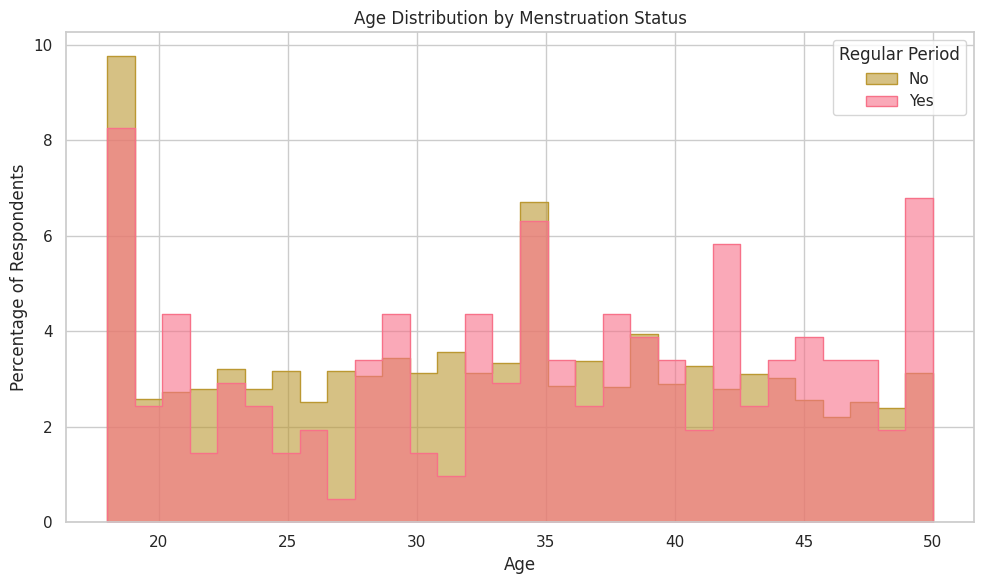

In [814]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(
    data=cleaned,
    x="Age_demo",
    hue="Regular_Periods_demo",   # split by menstruation status
    bins=30,
    stat="percent",         # percent makes groups directly comparable
    element="step",         # outlines for clarity
    common_norm=False,      # each group normalized separately
    alpha=0.6
)

plt.title("Age Distribution by Menstruation Status")
plt.xlabel("Age")
plt.ylabel("Percentage of Respondents")
plt.legend(title="Regular Period", labels=["No", "Yes"])
plt.tight_layout()
plt.show()


#### Step 2: Association for categorical features
For categorical predictors (like Gender, Race, Education, Attempted_to_lose_weight, Smoker_(100+_Cigs)), you can do Chi-square test:

In [815]:
from scipy.stats import chi2_contingency

categorical_cols = cleaned.select_dtypes(include=['object', 'category']).columns

# Exclude columns that contain 'Regular_Periods_'
categorical_cols  = [col for col in categorical_cols  if 'Regular_Periods_' not in col]

cat_results = []

for col in categorical_cols:
    contingency = pd.crosstab(cleaned['Regular_Periods_demo'], cleaned[col])
    chi2, p, dof, expected = chi2_contingency(contingency)
    cat_results.append({'Feature': col, 'Chi2': chi2, 'p-value': p})

cat_corr_df = pd.DataFrame(cat_results)
print(cat_corr_df.sort_values('p-value'))


                              Feature       Chi2   p-value
3                           Race_demo  19.280819  0.001704
4                      Education_demo  14.948211  0.004810
1                  Smoked_100_smoking   5.585656  0.018108
7                   Salt_Used_dietary   9.761126  0.020710
10     Work_Sleep_Time_Category_sleep   4.661779  0.030841
13  Nonwork_Sleep_Time_Category_sleep   4.661779  0.030841
11      Work_Wake_Time_Category_sleep   6.858437  0.032412
2      Household_Smoker_Count_smoking   6.173033  0.045661
12      Work_Sleep_Hrs_Category_sleep   3.933702  0.139897
0           Attempted_Weight_Loss_bmi   1.753461  0.185442
15   Nonwork_Sleep_Hrs_Category_sleep   3.335876  0.188636
8                     On_Diet_dietary   1.461064  0.226761
5                    Alc_Freq_alcohol   9.866909  0.452246
14   Nonwork_Wake_Time_Category_sleep   1.033977  0.596314
6                Daily_Drinks_alcohol   9.394674  0.668901
9                Dietary_Supp_dietary   0.101237  0.7503

In [816]:
import pandas as pd

# Copy df to avoid modifying original
chi2_table = cat_corr_df.copy()

# Round values for readability
chi2_table['Chi2'] = chi2_table['Chi2'].round(3)
chi2_table['p-value'] = chi2_table['p-value'].apply(lambda x: f"{x:.3e}")

# Add significance stars
def add_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# Convert formatted p-values back to float for star assignment
chi2_table['Significance'] = chi2_table['p-value'].apply(lambda x: add_stars(float(x.split('e')[0]) * 10**int(x.split('e')[1])))

# Reorder columns
chi2_table = chi2_table[['Feature', 'Chi2', 'p-value', 'Significance']]

# Create styled HTML table
def highlight_significant(val):
    if val in ['*', '**', '***']:
        return 'color: red; font-weight: bold'
    return ''

chi2_html = (
    chi2_table
    .style
    .applymap(highlight_significant, subset=['Significance'])
    .set_caption("Chi-square Test with Regular Period (Categorical Features)")
    .hide(axis="index")
    .set_table_styles([
        {'selector': 'caption',
         'props': 'caption-side: top; font-size:16px; font-weight:bold; color: black;'}
    ])
)

chi2_html


/tmp/ipykernel_18/4012480085.py:34: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  chi2_table


Feature,Chi2,p-value,Significance
Attempted_Weight_Loss_bmi,1.753000,1.854e-01,
Smoked_100_smoking,5.586000,1.811e-02,*
Household_Smoker_Count_smoking,6.173000,4.566e-02,*
Race_demo,19.281000,1.704e-03,**
Education_demo,14.948000,4.810e-03,**
Alc_Freq_alcohol,9.867000,4.522e-01,
Daily_Drinks_alcohol,9.395000,6.689e-01,
Salt_Used_dietary,9.761000,2.071e-02,*
On_Diet_dietary,1.461000,2.268e-01,
Dietary_Supp_dietary,0.101000,7.503e-01,


Race_demo                  Mexican American  Non-Hispanic Asian  \
Education_demo                                                    
9-11th grade                       0.982456            0.944444   
College graduate or above          0.867925            0.989637   
High school/GED                    0.942529            0.962963   
Less than 9th grade                0.833333            1.000000   
Some college/AA                    0.967532            0.986842   

Race_demo                  Non-Hispanic Black  Non-Hispanic White  \
Education_demo                                                      
9-11th grade                         0.915254            0.898305   
College graduate or above            0.952703            0.924945   
High school/GED                      0.893333            0.881657   
Less than 9th grade                  1.000000            1.000000   
Some college/AA                      0.950617            0.928279   

Race_demo                  Other Hispanic  Oth

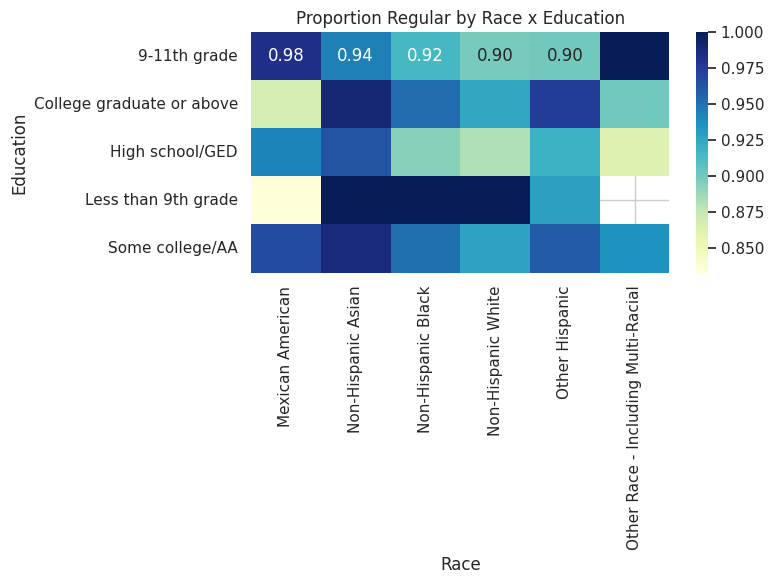

In [817]:
# ---- Compute mean Regular_Periods_demo by Race and Education ----
heat = (cleaned
        .groupby(['Race_demo','Education_demo'])['Regular_Periods_demo']
        .mean()
        .reset_index())

# ---- Pivot to make a matrix suitable for heatmap ----
pivot = heat.pivot(index='Education_demo', columns='Race_demo', values='Regular_Periods_demo')

print(pivot)

# ---- Plot heatmap ----
plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='YlGnBu')  # added a color map
plt.title('Proportion Regular by Race x Education')
plt.xlabel('Race')
plt.ylabel('Education')
plt.tight_layout()

In [487]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(style="whitegrid")

# ---- Compute proportions for each Race x Education group ----
prop_data = (
    cleaned
    .groupby(['Education_demo', 'Race_demo', 'Regular_Periods_demo'])
    .size()
    .groupby(level=[0,1])
    .apply(lambda x: x / x.sum())  # convert counts to proportions within each Race x Education group
    .reset_index(name='proportion')
)

# ---- Faceted bar plot by Education, hue = Regular_Periods_demo ----
g = sns.catplot(
    data=prop_data,
    x='Race_demo',
    y='proportion',
    hue='Regular_Periods_demo',
    col='Education_demo',
    kind='bar',
    col_wrap=3,
    height=4,
    aspect=1
)

g.set_axis_labels("Race", "Proportion")
g.set_titles("{col_name}")
g._legend.set_title("Regular Periods")
plt.subplots_adjust(top=0.9)
plt.suptitle('Proportion of Regular Periods by Race, faceted by Education')
plt.show()


ValueError: cannot insert Race_demo, already exists